# Import Libraries

In [ ]:
## install pyportfolio (Min-Var Portfolio Allocation)
!pip install PyPortfolioOpt

     |████████████████████████████████| 61 kB 2.8 MB/s 
     |████████████████████████████████| 2.8 MB 11.2 MB/s 
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.0.31:
      Successfully uninstalled cvxpy-1.0.31


In [ ]:
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-3u_ta42b
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-3u_ta42b
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-wfonkdc1/pyfolio_360cafe17540454a83aebf999624bd60
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-wfonkdc1/pyfolio_360cafe17540454a83aebf999624bd60
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-wfonkdc1/elegantrl_7a95a23404584e2a9cd566b2d18f9a23
  Running command git clone -q https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-wfonkdc1/elegantrl_7a95a23404584e2a9cd566b2d18f9a23
     |████████████████████████████████| 73 kB 1.6 MB/s 
     |████████████████████████████████| 174 kB 22.4 MB/s 
     |████████████████████████████████| 57.6 MB 1.3 MB/s 
     |████████████████████████████████| 1.8 MB 36.0 MB/s 
     |██████

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
matplotlib.use('Agg')
%matplotlib inline
import datetime

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models

from finrl.apps import config
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.data_processor import DataProcessor
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning:

Module "zipline.assets" not found; multipliers will not be applied to position notionals.



# Create Folders

In [ ]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

# **Functions**

## Stock Trading Normal Environment

In [ ]:
import gym
from gym import spaces
from gym.utils import seeding
from stable_baselines3.common.vec_env import DummyVecEnv

matplotlib.use("Agg")

class StockTradingEnv(gym.Env):

    metadata = {"render.modes": ["human"]}

    def __init__(self,
                 df,
                 stock_dim,
                 hmax,
                 initial_amount,
                 buy_cost_pct,
                 sell_cost_pct,
                 reward_scaling,
                 state_space,
                 action_space,
                 tech_indicator_list,
                 turbulence_threshold=None,
                 risk_indicator_col="turbulence",
                 make_plots=False,
                 print_verbosity=10,
                 day=0,
                 initial=True,
                 previous_state=[],
                 model_name="",
                 mode="",
                 iteration="",
                ):
        self.day = day
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.action_space,))
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.state_space,))
        self.data = self.df.loc[self.day, :]
        self.terminal = False
        self.make_plots = make_plots
        self.print_verbosity = print_verbosity
        self.turbulence_threshold = turbulence_threshold
        self.risk_indicator_col = risk_indicator_col
        self.initial = initial
        self.previous_state = previous_state
        self.model_name = model_name
        self.mode = mode
        self.iteration = iteration
        # initalize state
        self.state = self._initiate_state()
        # initialize reward
        self.reward = 0
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.episode = 0
        # memorize all the total balance change
        self.asset_memory = [self.initial_amount]
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]
        # self.reset()
        self._seed()

    def _sell_stock(self, index, action):
        def _do_sell_normal():
            if self.state[index + 1] > 0:
                # sell only if the price is > 0 (no missing data in this particular date)
                # perform sell action based on the sign of the action
                if self.state[index + self.stock_dim + 1] > 0:
                    # sell only if current asset is > 0
                    sell_num_shares = min(abs(action), self.state[index + self.stock_dim + 1])
                    sell_amount = (self.state[index + 1] * sell_num_shares * (1 - self.sell_cost_pct))
                    # update balance
                    self.state[0] += sell_amount
                    self.state[index + self.stock_dim + 1] -= sell_num_shares
                    self.cost += (self.state[index + 1] * sell_num_shares * self.sell_cost_pct)
                    self.trades += 1
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = 0
            return sell_num_shares

        # perform sell action based on the sign of the action
        if self.turbulence_threshold is not None:
            if self.turbulence >= self.turbulence_threshold:
                if self.state[index + 1] > 0:
                    # sell only if the price is > 0 (no missing data in this particular date)
                    # if turbulence goes over threshold, just clear out all positions
                    if self.state[index + self.stock_dim + 1] > 0:
                        # sell only if current asset is > 0
                        sell_num_shares = self.state[index + self.stock_dim + 1]
                        sell_amount = (self.state[index + 1] * sell_num_shares * (1 - self.sell_cost_pct))
                        # update balance
                        self.state[0] += sell_amount
                        self.state[index + self.stock_dim + 1] = 0
                        self.cost += (self.state[index + 1] * sell_num_shares * self.sell_cost_pct)
                        self.trades += 1
                    else:
                        sell_num_shares = 0
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = _do_sell_normal()
        else:
            sell_num_shares = _do_sell_normal()
        return sell_num_shares

    def _buy_stock(self, index, action):
        def _do_buy():
            if self.state[index + 1] > 0:
                # buy only if the price is > 0 (no missing data in this particular date)
                available_amount = self.state[0] // self.state[index + 1]
                 # update balance
                buy_num_shares = min(available_amount, action)
                buy_amount = (self.state[index + 1] * buy_num_shares * (1 + self.buy_cost_pct))
                self.state[0] -= buy_amount
                self.state[index + self.stock_dim + 1] += buy_num_shares
                self.cost += self.state[index + 1] * buy_num_shares * self.buy_cost_pct
                self.trades += 1
            else:
                buy_num_shares = 0
            return buy_num_shares

        # perform buy action based on the sign of the action
        if self.turbulence_threshold is None:
            buy_num_shares = _do_buy()
        else:
            if self.turbulence < self.turbulence_threshold:
                buy_num_shares = _do_buy()
            else:
                buy_num_shares = 0
                pass
        return buy_num_shares

    def _make_plot(self):
        plt.plot(self.asset_memory, "r")
        plt.savefig("results/account_value_trade_{}.png".format(self.episode))
        plt.close()

    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique()) - 1
        if self.terminal:
            if self.make_plots:
                self._make_plot()
            end_total_asset = self.state[0] + sum(np.array(self.state[1 : (self.stock_dim + 1)]) * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]))
            df_total_value = pd.DataFrame(self.asset_memory)
            tot_reward = (self.state[0] + sum(np.array(self.state[1 : (self.stock_dim + 1)]) * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]))- self.initial_amount)
            df_total_value.columns = ["account_value"]
            df_total_value["date"] = self.date_memory
            df_total_value["daily_return"] = df_total_value["account_value"].pct_change(1)
            if df_total_value["daily_return"].std() != 0:
                sharpe = ((252 ** 0.5)* df_total_value["daily_return"].mean() / df_total_value["daily_return"].std())
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.columns = ["account_rewards"]
            df_rewards["date"] = self.date_memory[:-1]
            if self.episode % self.print_verbosity == 0:
                print(f"day: {self.day}, episode: {self.episode}")
                print(f"begin_total_asset: {self.asset_memory[0]:0.2f}")
                print(f"end_total_asset: {end_total_asset:0.2f}")
                print(f"total_reward: {tot_reward:0.2f}")
                print(f"total_cost: {self.cost:0.2f}")
                print(f"total_trades: {self.trades}")
                if df_total_value["daily_return"].std() != 0:
                    print(f"Sharpe: {sharpe:0.3f}")
                print("=================================")
            if (self.model_name != "") and (self.mode != ""):
                df_actions = self.save_action_memory()
                df_actions.to_csv("results/actions_{}_{}_{}.csv".format(self.mode, self.model_name, self.iteration))
                df_total_value.to_csv("results/account_value_{}_{}_{}.csv".format(self.mode, self.model_name, self.iteration), index=False,)
                df_rewards.to_csv("results/account_rewards_{}_{}_{}.csv".format(self.mode, self.model_name, self.iteration), index=False,)
                plt.plot(self.asset_memory, "r")
                plt.savefig("results/account_value_{}_{}_{}.png".format(self.mode, self.model_name, self.iteration), index=False,)
                plt.close()
            return self.state, self.reward, self.terminal, {}

        else:
            actions = actions * self.hmax  # actions initially is scaled between 0 to 1
            actions = actions.astype(int)  # convert into integer because we can't by fraction of shares
            if self.turbulence_threshold is not None:
                if self.turbulence >= self.turbulence_threshold:
                    actions = np.array([-self.hmax] * self.stock_dim)
            begin_total_asset = self.state[0] + sum(np.array(self.state[1 : (self.stock_dim + 1)]) * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]))
            argsort_actions = np.argsort(actions)
            sell_index = argsort_actions[: np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][: np.where(actions > 0)[0].shape[0]]
            for index in sell_index:
                actions[index] = self._sell_stock(index, actions[index]) * (-1)
            for index in buy_index:
                actions[index] = self._buy_stock(index, actions[index])
            self.actions_memory.append(actions)
            # state: s -> s+1
            self.day += 1
            self.data = self.df.loc[self.day, :]
            if self.turbulence_threshold is not None:
                if len(self.df.tic.unique()) == 1:
                    self.turbulence = self.data[self.risk_indicator_col]
                elif len(self.df.tic.unique()) > 1:
                    self.turbulence = self.data[self.risk_indicator_col].values[0]
            self.state = self._update_state()
            end_total_asset = self.state[0] + sum(np.array(self.state[1 : (self.stock_dim + 1)]) * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]))
            self.asset_memory.append(end_total_asset)
            self.date_memory.append(self._get_date())
            self.reward = end_total_asset - begin_total_asset
            self.rewards_memory.append(self.reward)
            self.reward = self.reward * self.reward_scaling
        return self.state, self.reward, self.terminal, {}

    def reset(self):
        # initiate state
        self.state = self._initiate_state()
        if self.initial:
            self.asset_memory = [self.initial_amount]
        else:
            previous_total_asset = self.previous_state[0] + sum(np.array(self.state[1 : (self.stock_dim + 1)]) * np.array(self.previous_state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]))
            self.asset_memory = [previous_total_asset]
        self.day = 0
        self.data = self.df.loc[self.day, :]
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.terminal = False
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]
        self.episode += 1
        return self.state

    def render(self, mode="human", close=False):
        return self.state

    def _initiate_state(self):
        if self.initial:
            # for initial state
            if len(self.df.tic.unique()) > 1:
                # for multiple stock
                state = ([self.initial_amount]
                         + self.data.close.values.tolist()
                         + [0] * self.stock_dim
                         + sum([self.data[tech].values.tolist() 
                                for tech in self.tech_indicator_list],[],))
            else:
                # for single stock
                state = (
                    [self.initial_amount]
                    + [self.data.close]
                    + [0] * self.stock_dim
                    + sum([[self.data[tech]] 
                           for tech in self.tech_indicator_list], []))
        else:
            # using Previous State
            if len(self.df.tic.unique()) > 1:
                # for multiple stock
                state = ([self.previous_state[0]]
                         + self.data.close.values.tolist()
                         + self.previous_state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]
                         + sum([self.data[tech].values.tolist() 
                                for tech in self.tech_indicator_list],[],))
            else:
                # for single stock
                state = ([self.previous_state[0]]
                         + [self.data.close]
                         + self.previous_state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]
                         + sum([[self.data[tech]] 
                                for tech in self.tech_indicator_list], []))
        return state

    def _update_state(self):
        if len(self.df.tic.unique()) > 1:
            # for multiple stock
            state = ([self.state[0]]
                     + self.data.close.values.tolist()
                     + list(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
                     + sum([self.data[tech].values.tolist() 
                            for tech in self.tech_indicator_list],[],))
        else:
            # for single stock
            state = ([self.state[0]]
                     + [self.data.close]
                     + list(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
                     + sum([[self.data[tech]] 
                                for tech in self.tech_indicator_list], []))
        return state

    def _get_date(self):
        if len(self.df.tic.unique()) > 1:
            date = self.data.date.unique()[0]
        else:
            date = self.data.date
        return date

    def save_asset_memory(self):
        date_list = self.date_memory
        asset_list = self.asset_memory
        df_account_value = pd.DataFrame({"date": date_list, "account_value": asset_list})
        return df_account_value

    def save_action_memory(self):
        if len(self.df.tic.unique()) > 1:
            # date and close price length must match actions length
            date_list = self.date_memory[:-1]
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]
            action_list = self.actions_memory
            df_actions = pd.DataFrame(action_list)
            df_actions.columns = self.data.tic.values
            df_actions.index = df_date.date
        else:
            date_list = self.date_memory[:-1]
            action_list = self.actions_memory
            df_actions = pd.DataFrame({"date": date_list, "actions": action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

## Stable Baselines 3 DRL Models & Agents

In [ ]:
import time

from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.noise import (NormalActionNoise, OrnsteinUhlenbeckActionNoise,)

MODELS = {"a2c": A2C, "ddpg": DDPG, "td3": TD3, "sac": SAC, "ppo": PPO}

MODEL_KWARGS = {x: config.__dict__[f"{x.upper()}_PARAMS"] for x in MODELS.keys()}

NOISE = {"normal": NormalActionNoise, "ornstein_uhlenbeck": OrnsteinUhlenbeckActionNoise,}

class TensorboardCallback(BaseCallback):
    """
    Custom callback for plotting additional values in tensorboard
    """

    def __init__(self, verbose=0):
        super(TensorboardCallback, self).__init__(verbose)

    def _on_step(self) -> bool:
        try:
            self.logger.record(key="train/reward", value=self.locals["rewards"][0])
        except BaseException:
            self.logger.record(key="train/reward", value=self.locals["reward"][0])
        return True

class DRLAgent:
    """
    Provides implementations for DRL algorithms
    Attributes
    ----------
        env: gym environment class
            user-defined class
    Methods
    -------
        get_model()
            setup DRL algorithms
        train_model()
            train DRL algorithms in a train dataset
            and output the trained model
        DRL_prediction()
            make a prediction in a test dataset and get results
    """

    def __init__(self, env):
        self.env = env

    def get_model(self, 
                  model_name, 
                  policy="MlpPolicy", 
                  policy_kwargs=None, 
                  model_kwargs=None, 
                  verbose=1, 
                  seed=None, 
                  tensorboard_log=None,
                 ):
        if model_name not in MODELS:
            raise NotImplementedError("NotImplementedError")
        if model_kwargs is None:
            model_kwargs = MODEL_KWARGS[model_name]
        if "action_noise" in model_kwargs:
            n_actions = self.env.action_space.shape[-1]
            model_kwargs["action_noise"] = NOISE[model_kwargs["action_noise"]](mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
        print(model_kwargs)
        model = MODELS[model_name](policy=policy,
                                   env=self.env,
                                   tensorboard_log=tensorboard_log,
                                   verbose=verbose,
                                   policy_kwargs=policy_kwargs,
                                   seed=seed,
                                   **model_kwargs,)
        return model

    def train_model(self, model, tb_log_name, total_timesteps=5000):
        model = model.learn(total_timesteps=total_timesteps, 
                            tb_log_name=tb_log_name, 
                            callback=TensorboardCallback(),)
        return model

    @staticmethod
    def DRL_prediction(model, environment):
        test_env, test_obs = environment.get_sb_env()
        """
        Make a prediction
        """
        account_memory = []
        actions_memory = []
        test_env.reset()
        for i in range(len(environment.df.index.unique())):
            action, _states = model.predict(test_obs)
            test_obs, rewards, dones, info = test_env.step(action)
            if i == (len(environment.df.index.unique()) - 2):
                account_memory = test_env.env_method(method_name="save_asset_memory")
                actions_memory = test_env.env_method(method_name="save_action_memory")
            if dones[0]:
                print("hit end!")
                break
        return account_memory[0], actions_memory[0]

    @staticmethod
    def DRL_prediction_load_from_file(model_name, environment, cwd):
        if model_name not in MODELS:
            raise NotImplementedError("NotImplementedError")
        try:
            # load agent
            model = MODELS[model_name].load(cwd)
            print("Successfully load model", cwd)
        except BaseException:
            raise ValueError("Fail to load agent!")
        # test on the testing env
        state = environment.reset()
        episode_returns = list()  # the cumulative_return / initial_account
        episode_total_assets = list()
        episode_total_assets.append(environment.initial_total_asset)
        done = False
        while not done:
            action = model.predict(state)[0]
            state, reward, done, _ = environment.step(action)
            total_asset = (environment.amount + (environment.price_ary[environment.day] * environment.stocks).sum())
            episode_total_assets.append(total_asset)
            episode_return = total_asset / environment.initial_total_asset
            episode_returns.append(episode_return)
        print("episode_return", episode_return)
        print("Test Finished!")
        return episode_total_assets


# Download Data

In [ ]:
# DOW_30_TICKER
# NAS_100_TICKER
# SP_500_TICKER 

In [ ]:
# index constituents
print(config.NAS_100_TICKER)

['AMGN', 'AAPL', 'AMAT', 'INTC', 'PCAR', 'PAYX', 'MSFT', 'ADBE', 'CSCO', 'XLNX', 'QCOM', 'COST', 'SBUX', 'FISV', 'CTXS', 'INTU', 'AMZN', 'EBAY', 'BIIB', 'CHKP', 'GILD', 'NLOK', 'CMCSA', 'FAST', 'ADSK', 'CTSH', 'NVDA', 'GOOGL', 'ISRG', 'VRTX', 'HSIC', 'BIDU', 'ATVI', 'ADP', 'ROST', 'ORLY', 'CERN', 'BKNG', 'MYL', 'MU', 'DLTR', 'ALXN', 'SIRI', 'MNST', 'AVGO', 'TXN', 'MDLZ', 'FB', 'ADI', 'WDC', 'REGN', 'LBTYK', 'VRSK', 'NFLX', 'TSLA', 'CHTR', 'MAR', 'ILMN', 'LRCX', 'EA', 'AAL', 'WBA', 'KHC', 'BMRN', 'JD', 'SWKS', 'INCY', 'PYPL', 'CDW', 'FOXA', 'MXIM', 'TMUS', 'EXPE', 'TCOM', 'ULTA', 'CSX', 'NTES', 'MCHP', 'CTAS', 'KLAC', 'HAS', 'JBHT', 'IDXX', 'WYNN', 'MELI', 'ALGN', 'CDNS', 'WDAY', 'SNPS', 'ASML', 'TTWO', 'PEP', 'NXPI', 'XEL', 'AMD', 'NTAP', 'VRSN', 'LULU', 'WLTW', 'UAL']


In [ ]:
df = YahooDownloader(start_date = '2000-01-01',
                     end_date = '2021-11-01',
                     ticker_list = config.NAS_100_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
df

,date,open,high,low,close,volume,tic,day
0,2000-01-03,0.936384,1.004464,0.907924,0.856887,535796800.0,AAPL,0
1,2000-01-03,16.812500,16.875000,16.062500,16.274670,7384400.0,ADBE,0
2,2000-01-03,46.750000,46.937500,44.000000,29.667692,3655600.0,ADI,0
3,2000-01-03,42.428928,42.775894,41.189766,25.976377,2698899.0,ADP,0
4,2000-01-03,8.500000,8.656250,8.031250,8.052909,2845600.0,ADSK,0
...,...,...,...,...,...,...,...,...
474526,2021-10-29,49.919998,53.500000,49.500000,52.290001,18239400.0,WDC,4
474527,2021-10-29,246.990005,248.809998,239.690002,242.279999,2288400.0,WLTW,4
474528,2021-10-29,90.650002,91.449997,88.769997,89.800003,2957700.0,WYNN,4
474529,2021-10-29,65.519997,65.599998,64.089996,64.589996,4082900.0,XEL,4


# Preprocess Data

In [ ]:
# technical indicators list
config.TECHNICAL_INDICATORS_LIST

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [ ]:
# add technical indicators, vix and turbulence
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = config.TECHNICAL_INDICATORS_LIST,
                     use_vix=True,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (5492, 8)
Successfully added vix
Successfully added turbulence index


In [ ]:
processed

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2000-01-03,0.936384,1.004464,0.907924,0.856887,535796800.0,AAPL,0,0.000000,0.922933,0.718596,0.000000,-66.666667,100.000000,0.856887,0.856887,24.209999,0.000000
1,2000-01-03,16.812500,16.875000,16.062500,16.274670,7384400.0,ADBE,0,0.000000,0.922933,0.718596,0.000000,-66.666667,100.000000,16.274670,16.274670,24.209999,0.000000
2,2000-01-03,46.750000,46.937500,44.000000,29.667692,3655600.0,ADI,0,0.000000,0.922933,0.718596,0.000000,-66.666667,100.000000,29.667692,29.667692,24.209999,0.000000
3,2000-01-03,42.428928,42.775894,41.189766,25.976377,2698899.0,ADP,0,0.000000,0.922933,0.718596,0.000000,-66.666667,100.000000,25.976377,25.976377,24.209999,0.000000
4,2000-01-03,8.500000,8.656250,8.031250,8.052909,2845600.0,ADSK,0,0.000000,0.922933,0.718596,0.000000,-66.666667,100.000000,8.052909,8.052909,24.209999,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362467,2021-10-28,181.190002,183.830002,181.009995,182.000000,1356700.0,VRTX,3,-0.769586,187.090115,176.283889,43.879855,-12.260463,25.104128,182.503335,189.037501,16.530001,198.476501
362468,2021-10-28,47.080002,47.349998,46.660000,46.649181,4843900.0,WBA,3,-0.111101,49.586806,45.415096,46.118052,-103.269560,0.268701,47.628716,48.092658,16.530001,198.476501
362469,2021-10-28,55.860001,57.340000,55.840000,57.279999,4112600.0,WDC,3,-0.464545,58.114225,54.402775,46.653571,20.003535,1.780329,56.590333,59.233333,16.530001,198.476501
362470,2021-10-28,63.080002,64.589996,62.330002,64.330002,3178400.0,XEL,3,-0.094605,66.394726,62.163276,46.979416,-7.585519,33.946424,63.818667,66.046343,16.530001,198.476501


In [ ]:
# data wrangling
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [ ]:
processed_full

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2000-01-03,AAPL,0.936384,1.004464,0.907924,0.856887,535796800.0,0.0,0.000000,0.922933,0.718596,0.000000,-66.666667,100.000000,0.856887,0.856887,24.209999,0.000000
1,2000-01-03,ADBE,16.812500,16.875000,16.062500,16.274670,7384400.0,0.0,0.000000,0.922933,0.718596,0.000000,-66.666667,100.000000,16.274670,16.274670,24.209999,0.000000
2,2000-01-03,ADI,46.750000,46.937500,44.000000,29.667692,3655600.0,0.0,0.000000,0.922933,0.718596,0.000000,-66.666667,100.000000,29.667692,29.667692,24.209999,0.000000
3,2000-01-03,ADP,42.428928,42.775894,41.189766,25.976377,2698899.0,0.0,0.000000,0.922933,0.718596,0.000000,-66.666667,100.000000,25.976377,25.976377,24.209999,0.000000
4,2000-01-03,ADSK,8.500000,8.656250,8.031250,8.052909,2845600.0,0.0,0.000000,0.922933,0.718596,0.000000,-66.666667,100.000000,8.052909,8.052909,24.209999,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526015,2021-10-28,VRTX,181.190002,183.830002,181.009995,182.000000,1356700.0,3.0,-0.769586,187.090115,176.283889,43.879855,-12.260463,25.104128,182.503335,189.037501,16.530001,198.476501
526016,2021-10-28,WBA,47.080002,47.349998,46.660000,46.649181,4843900.0,3.0,-0.111101,49.586806,45.415096,46.118052,-103.269560,0.268701,47.628716,48.092658,16.530001,198.476501
526017,2021-10-28,WDC,55.860001,57.340000,55.840000,57.279999,4112600.0,3.0,-0.464545,58.114225,54.402775,46.653571,20.003535,1.780329,56.590333,59.233333,16.530001,198.476501
526018,2021-10-28,XEL,63.080002,64.589996,62.330002,64.330002,3178400.0,3.0,-0.094605,66.394726,62.163276,46.979416,-7.585519,33.946424,63.818667,66.046343,16.530001,198.476501


In [ ]:
# set turbulance threshold
data_risk_indicator = processed_full[(processed_full.date<'2020-01-01') & (processed_full.date>='2000-01-01')]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

# **Multiple Stock Trading**

## Design Environment

In [ ]:
train = data_split(processed_full, '2000-01-01','2020-01-01')
trade = data_split(processed_full, '2020-01-01','2021-10-01')
print(len(train))
print(len(trade))

316953
27783


In [ ]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.TECHNICAL_INDICATORS_LIST)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 63, State Space: 631


In [ ]:
env_kwargs = {"hmax": 100, 
              "initial_amount": 1000000, 
              "buy_cost_pct": 0.001,
              "sell_cost_pct": 0.001,
              "state_space": state_space, 
              "stock_dim": stock_dimension, 
              "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
              "action_space": stock_dimension, 
              "reward_scaling": 1e-4}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [ ]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


## Implement DRL Algorithms

In [ ]:
# Model 1: A2C (Normal Env)
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c", verbose = 500)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device


In [ ]:
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=25000)

--------------------------------------
| time/                 |            |
|    fps                | 30         |
|    iterations         | 100        |
|    time_elapsed       | 16         |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -93.9      |
|    explained_variance | -0.319     |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -63.3      |
|    reward             | 0.26815176 |
|    std                | 1          |
|    value_loss         | 0.624      |
--------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 31           |
|    iterations         | 200          |
|    time_elapsed       | 32           |
|    total_timesteps    | 1000         |
| train/                |              |
|    entropy_loss       | -94.2        |
|    explained_variance | -0.733       |
|    le

In [ ]:
# Model 2: PPO (Normal Env)
agent = DRLAgent(env = env_train)
PPO_PARAMS = {"n_steps": 2048,
              "ent_coef": 0.01,
              "learning_rate": 0.00025,
              "batch_size": 64}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cuda device


In [ ]:
trained_ppo = agent.train_model(model=model_ppo, 
                                tb_log_name='ppo',
                                total_timesteps=25000)

-------------------------------------
| time/              |              |
|    fps             | 33           |
|    iterations      | 1            |
|    time_elapsed    | 60           |
|    total_timesteps | 2048         |
| train/             |              |
|    reward          | -0.003416237 |
-------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 33           |
|    iterations           | 2            |
|    time_elapsed         | 123          |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.061717376  |
|    clip_fraction        | 0.47         |
|    clip_range           | 0.2          |
|    entropy_loss         | -93.8        |
|    explained_variance   | -2.25        |
|    learning_rate        | 0.00025      |
|    loss                 | -1.04        |
|    n_updates            | 10           |
|    policy_g

In [ ]:
# Model 3: DDPG (Normal Env)
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device


In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                                 tb_log_name='ddpg',
                                 total_timesteps=25000)

-------------------------------------
| time/              |              |
|    episodes        | 4            |
|    fps             | 26           |
|    time_elapsed    | 759          |
|    total_timesteps | 20124        |
| train/             |              |
|    actor_loss      | -0.24        |
|    critic_loss     | 0.0811       |
|    learning_rate   | 0.001        |
|    n_updates       | 15093        |
|    reward          | 0.0060083424 |
-------------------------------------


In [ ]:
# Model 4: TD3 (Normal Env)
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 64, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}
model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

{'batch_size': 64, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cuda device


In [ ]:
trained_td3 = agent.train_model(model=model_td3, 
                                tb_log_name='td3',
                                total_timesteps=25000)

------------------------------------
| time/              |             |
|    episodes        | 4           |
|    fps             | 27          |
|    time_elapsed    | 719         |
|    total_timesteps | 20124       |
| train/             |             |
|    actor_loss      | 2.81        |
|    critic_loss     | 0.155       |
|    learning_rate   | 0.001       |
|    n_updates       | 15093       |
|    reward          | 0.018616658 |
------------------------------------


In [ ]:
# Model 5: SAC (Normal Env)
agent = DRLAgent(env = env_train)
SAC_PARAMS = {"batch_size": 64,
              "buffer_size": 1000000,
              "learning_rate": 0.0001,
              "learning_starts": 100,
              "ent_coef": "auto_0.1"}
model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 64, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device


In [ ]:
trained_sac = agent.train_model(model=model_sac, 
                                tb_log_name='sac',
                                total_timesteps=25000)

-------------------------------------
| time/              |              |
|    episodes        | 4            |
|    fps             | 19           |
|    time_elapsed    | 1039         |
|    total_timesteps | 20124        |
| train/             |              |
|    actor_loss      | -73.5        |
|    critic_loss     | 0.709        |
|    ent_coef        | 0.0139       |
|    ent_coef_loss   | -446         |
|    learning_rate   | 0.0001       |
|    n_updates       | 20023        |
|    reward          | 0.0035643142 |
-------------------------------------


# Trade

In [ ]:
# stock trading parameters
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70, risk_indicator_col='vix', **env_kwargs)
env_trade, obs_trade = e_trade_gym.get_sb_env()

In [ ]:
# Model 1: A2C (Normal Env)
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(model=trained_a2c, 
                                                               environment = e_trade_gym)

hit end!


In [ ]:
# Model 2: PPO (Normal Env)
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(model=trained_ppo, 
                                                               environment = e_trade_gym)

hit end!


In [ ]:
# Model 3: DDPG (Normal Env)
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(model=trained_ddpg, 
                                                                 environment = e_trade_gym)

hit end!


In [ ]:
# Model 4: TD3 (Normal Env)
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(model=trained_td3, 
                                                               environment = e_trade_gym)

hit end!


In [ ]:
# Model 5: SAC (Normal Env)
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(model=trained_sac, 
                                                               environment = e_trade_gym)

hit end!


# Back Test Stats

In [ ]:
# Model 1: A2C (Normal Env)
print("==========A2C Backtest Results==========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value_a2c)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_a2c_"+now+'.csv')

==========A2C Backtest Results==========
Annual return          0.431276
Cumulative returns     0.872906
Annual volatility      0.316139
Sharpe ratio           1.295444
Calmar ratio           1.631910
Stability              0.896776
Max drawdown          -0.264277
Omega ratio            1.251995
Sortino ratio          1.906265
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.995362
Daily value at risk   -0.038205
dtype: float64


In [ ]:
# Model 2: PPO (Normal Env)
print("==========PPO Backtest Results==========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value_ppo)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_ppo_"+now+'.csv')

==========PPO Backtest Results==========
Annual return          0.168965
Cumulative returns     0.314173
Annual volatility      0.255196
Sharpe ratio           0.741198
Calmar ratio           0.649045
Stability              0.848723
Max drawdown          -0.260329
Omega ratio            1.143631
Sortino ratio          1.041692
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.917115
Daily value at risk   -0.031401
dtype: float64


In [ ]:
# Model 3: DDPG (Normal Env)
print("==========DDPG Backtest Results==========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value_ddpg)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_ddpg_"+now+'.csv')

==========DDPG Backtest Results==========
Annual return          0.205504
Cumulative returns     0.386899
Annual volatility      0.267076
Sharpe ratio           0.835913
Calmar ratio           0.644919
Stability              0.843727
Max drawdown          -0.318650
Omega ratio            1.168069
Sortino ratio          1.144900
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.847423
Daily value at risk   -0.032763
dtype: float64


In [ ]:
# Model 4: TD3 (Normal Env)
print("==========TD3 Backtest Results==========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value_td3)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_td3_"+now+'.csv')

==========TD3 Backtest Results==========
Annual return          0.211536
Cumulative returns     0.399068
Annual volatility      0.282936
Sharpe ratio           0.822723
Calmar ratio           0.797300
Stability              0.864873
Max drawdown          -0.265316
Omega ratio            1.166541
Sortino ratio          1.122695
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.929698
Daily value at risk   -0.034723
dtype: float64


In [ ]:
# Model 5: SAC (Normal Env)
print("==========SAC Backtest Results==========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value_sac)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_sac_"+now+'.csv')

==========SAC Backtest Results==========
Annual return          0.150810
Cumulative returns     0.278664
Annual volatility      0.256217
Sharpe ratio           0.678238
Calmar ratio           0.528715
Stability              0.827408
Max drawdown          -0.285238
Omega ratio            1.132626
Sortino ratio          0.944846
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.941211
Daily value at risk   -0.031591
dtype: float64


# Back Test Plot

==========Compare A2C To Benchmark==========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (440, 8)


Start date,2020-01-02
End date,2021-09-30
Total months,21
,Backtest
Annual return,43.128%
Cumulative returns,87.291%
Annual volatility,31.614%
Sharpe ratio,1.30
Calmar ratio,1.63
Stability,0.90
Max drawdown,-26.428%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,26.43,2020-02-19,2020-03-23,2020-06-05,78
1,17.16,2021-02-12,2021-03-08,2021-06-17,90
2,11.07,2020-09-02,2020-09-23,2020-10-09,28
3,9.75,2021-01-11,2021-01-29,2021-02-12,25
4,7.51,2020-11-06,2020-11-10,2020-11-27,16


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning:

Passed returns do not overlap with anyinteresting times.



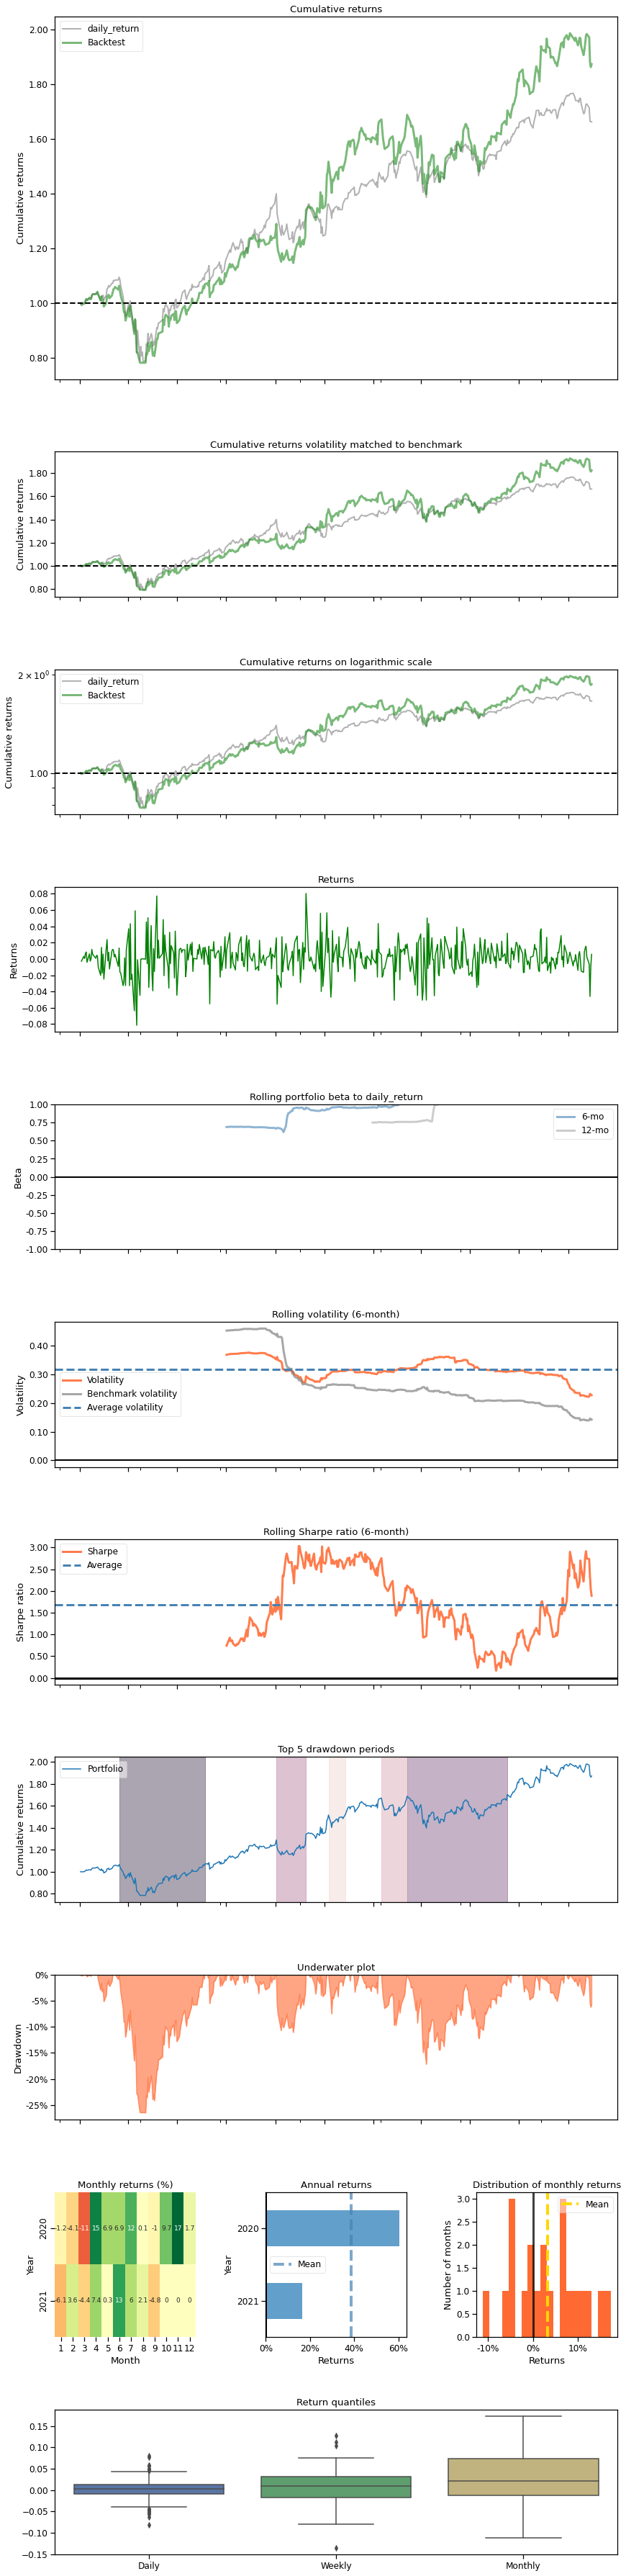

In [ ]:
# Model 1: A2C (Normal Env)
print("==========Compare A2C To Benchmark==========")
%matplotlib inline
backtest_plot(df_account_value_a2c, 
              baseline_ticker = 'NDX', 
              baseline_start = df_account_value_a2c.loc[0,'date'],
              baseline_end = df_account_value_a2c.loc[len(df_account_value_a2c)-1,'date'])

==========Compare PPO To Benchmark==========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (440, 8)


Start date,2020-01-02
End date,2021-09-30
Total months,21
,Backtest
Annual return,16.896%
Cumulative returns,31.417%
Annual volatility,25.52%
Sharpe ratio,0.74
Calmar ratio,0.65
Stability,0.85
Max drawdown,-26.033%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,26.03,2020-02-19,2020-03-23,2020-06-08,79
1,10.22,2021-02-12,2021-03-08,2021-04-01,35
2,9.69,2020-09-02,2020-10-30,2020-11-06,48
3,8.06,2021-04-27,2021-05-12,2021-06-14,35
4,5.99,2021-08-30,2021-09-30,NaT,NaN


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning:

Passed returns do not overlap with anyinteresting times.



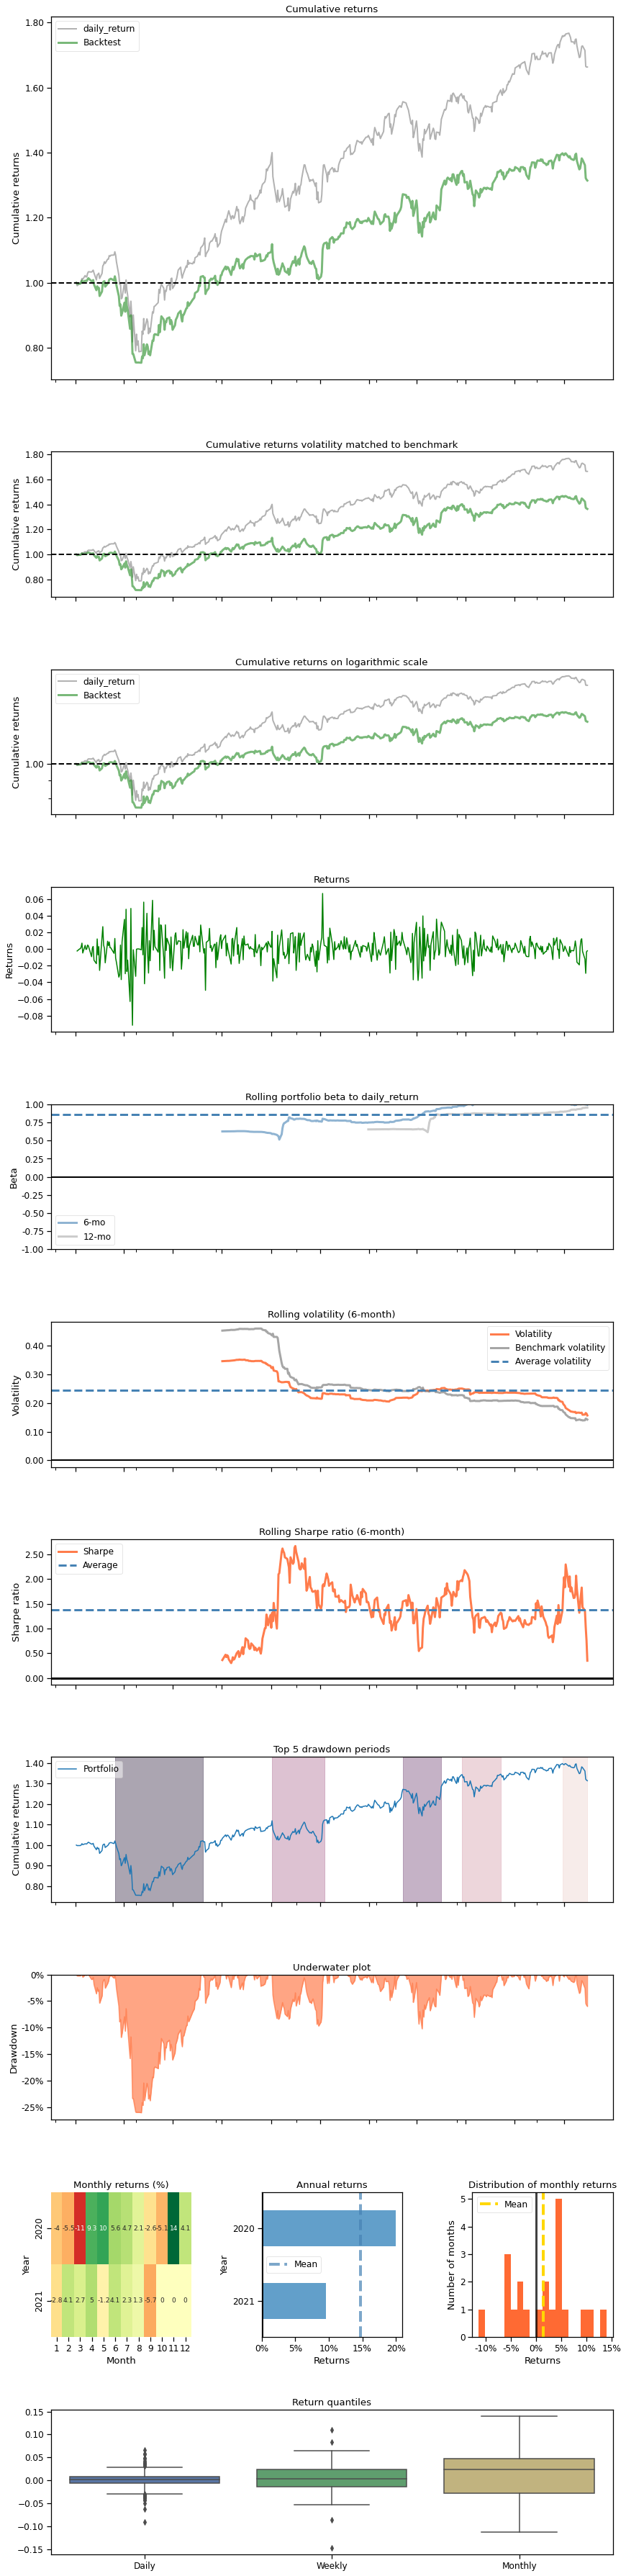

In [ ]:
# Model 2: PPO (Normal Env)
print("==========Compare PPO To Benchmark==========")
%matplotlib inline
backtest_plot(df_account_value_ppo, 
              baseline_ticker = 'NDX', 
              baseline_start = df_account_value_ppo.loc[0,'date'],
              baseline_end = df_account_value_ppo.loc[len(df_account_value_ppo)-1,'date'])

==========Compare DDPG To Benchmark==========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (440, 8)


Start date,2020-01-02
End date,2021-09-30
Total months,21
,Backtest
Annual return,20.55%
Cumulative returns,38.69%
Annual volatility,26.708%
Sharpe ratio,0.84
Calmar ratio,0.64
Stability,0.84
Max drawdown,-31.865%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,31.87,2020-02-19,2020-03-17,2020-07-06,99
1,12.32,2020-09-02,2020-09-21,2020-11-25,61
2,8.25,2021-04-29,2021-05-12,2021-07-06,49
3,7.58,2021-02-19,2021-03-04,2021-04-01,30
4,5.74,2021-01-21,2021-01-29,2021-02-11,16


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning:

Passed returns do not overlap with anyinteresting times.



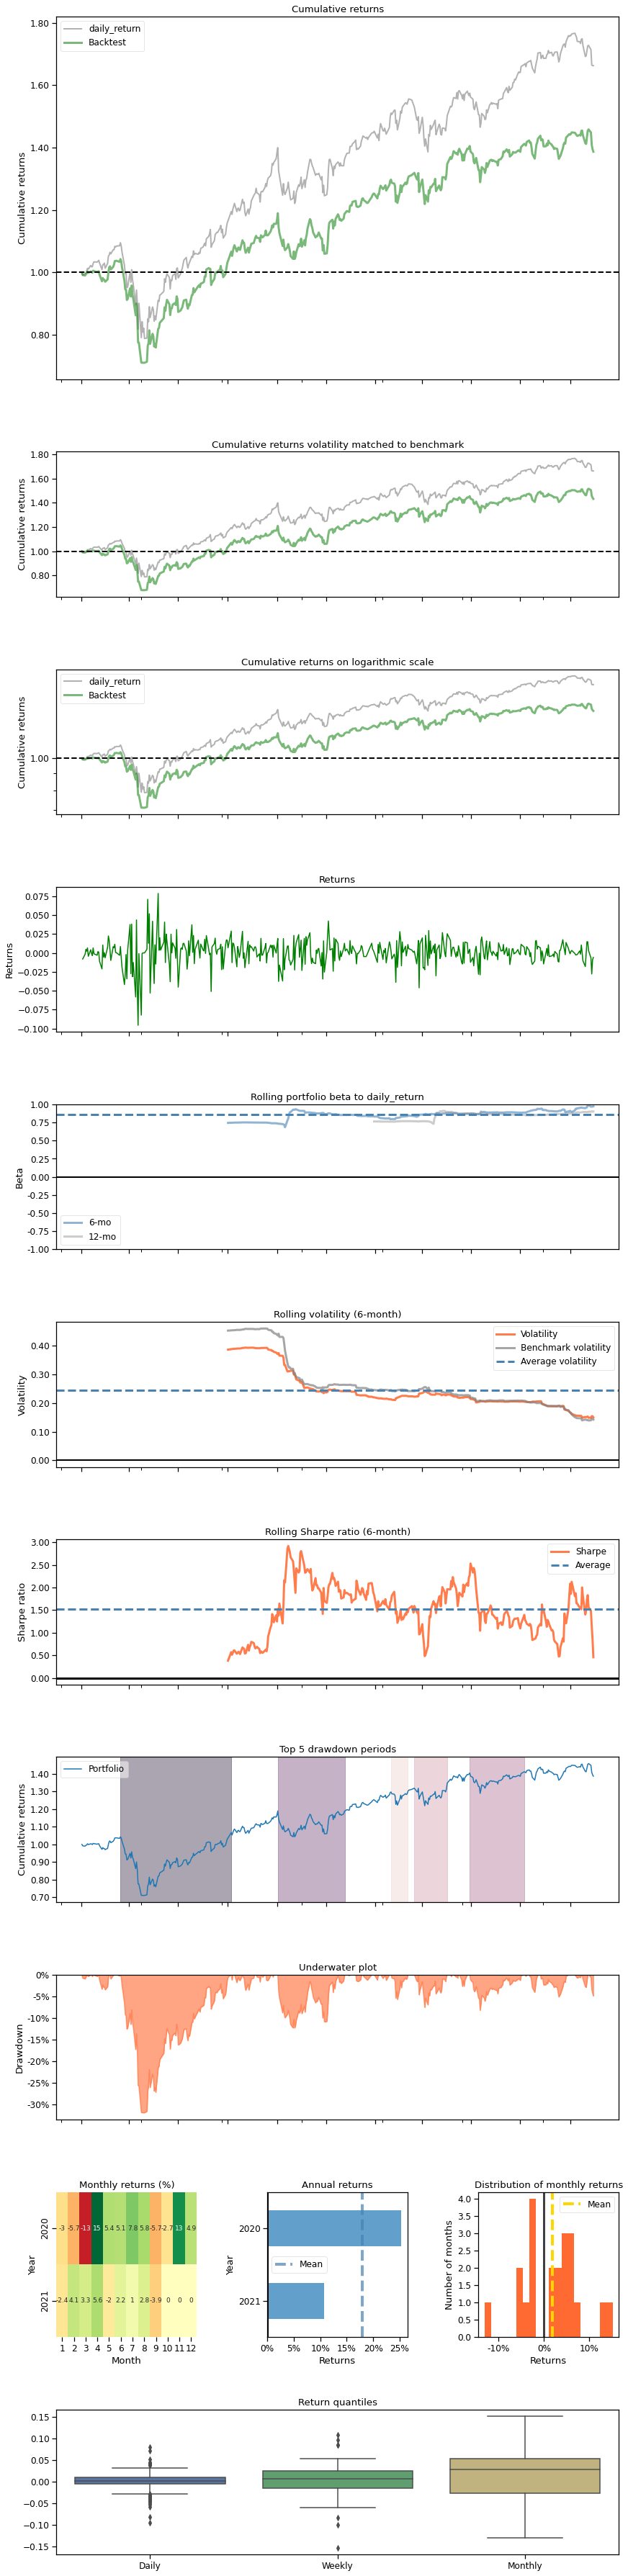

In [ ]:
# Model 3: DDPG (Normal Env)
print("==========Compare DDPG To Benchmark==========")
%matplotlib inline
backtest_plot(df_account_value_ddpg, 
              baseline_ticker = 'NDX', 
              baseline_start = df_account_value_ddpg.loc[0,'date'],
              baseline_end = df_account_value_ddpg.loc[len(df_account_value_ddpg)-1,'date'])

==========Compare TD3 To Benchmark==========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (440, 8)


Start date,2020-01-02
End date,2021-09-30
Total months,21
,Backtest
Annual return,21.154%
Cumulative returns,39.907%
Annual volatility,28.294%
Sharpe ratio,0.82
Calmar ratio,0.80
Stability,0.86
Max drawdown,-26.532%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,26.53,2020-02-19,2020-03-23,2020-05-29,73
1,13.73,2021-07-02,2021-07-19,NaT,NaN
2,11.36,2021-02-16,2021-03-08,2021-04-05,35
3,10.00,2020-09-02,2020-09-08,2020-10-13,30
4,9.72,2020-10-13,2020-10-30,2020-12-01,36


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning:

Passed returns do not overlap with anyinteresting times.



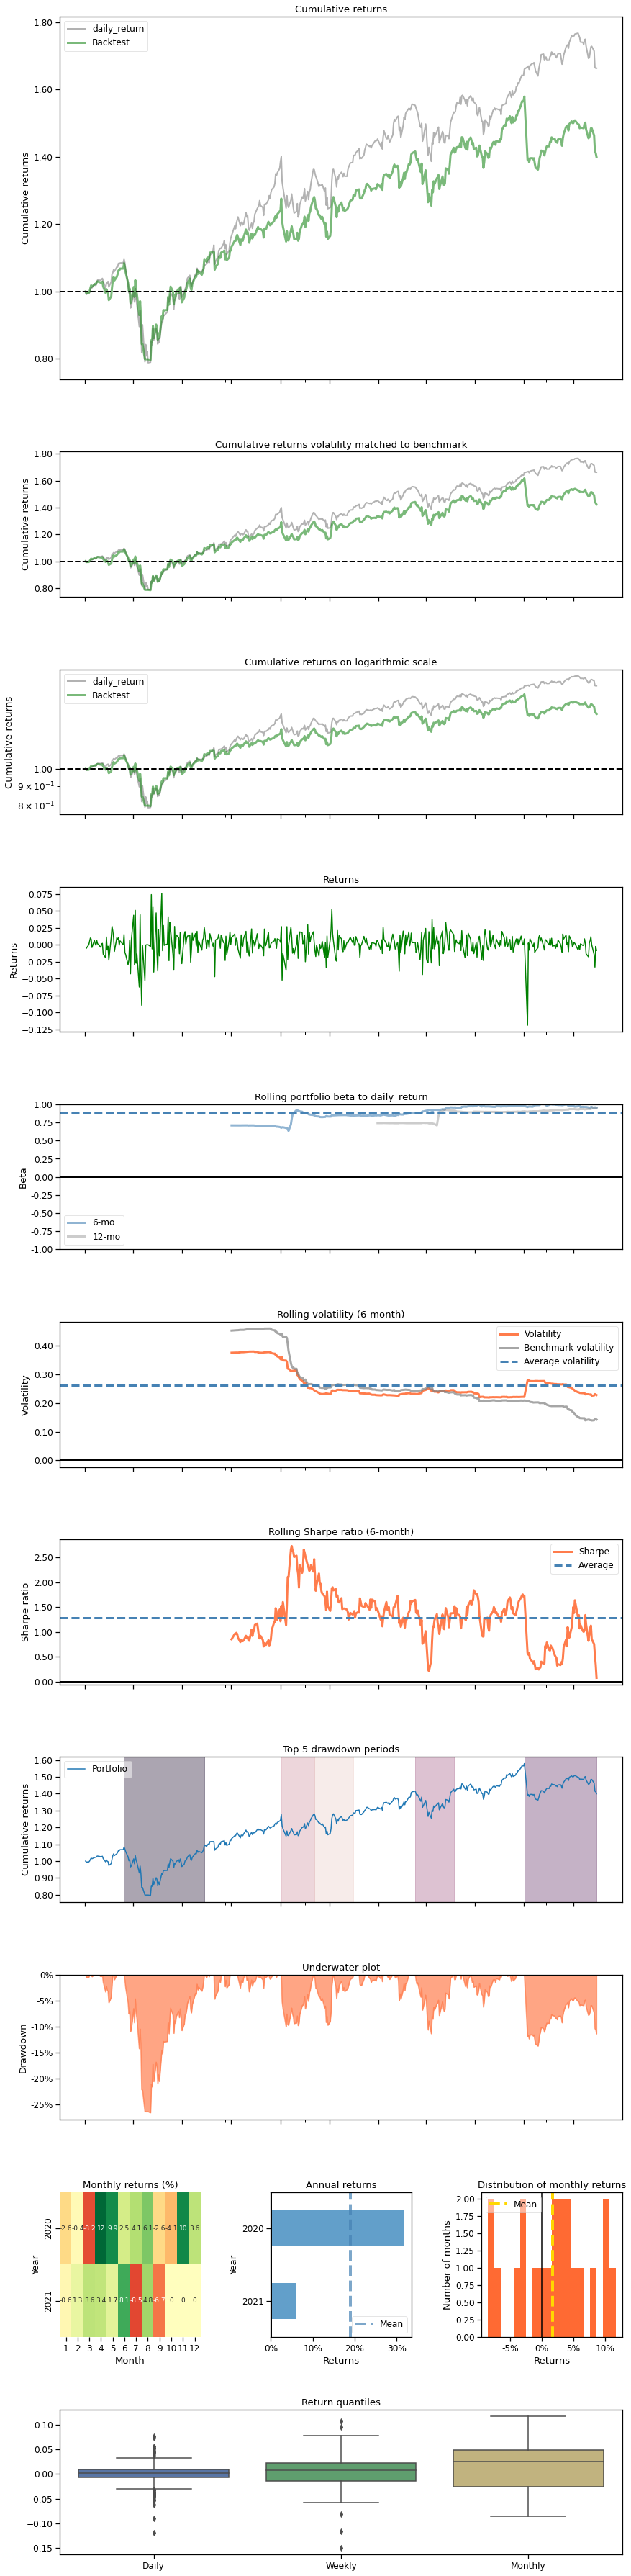

In [ ]:
# Model 4: TD3 (Normal Env)
print("==========Compare TD3 To Benchmark==========")
%matplotlib inline
backtest_plot(df_account_value_td3, 
              baseline_ticker = 'NDX', 
              baseline_start = df_account_value_td3.loc[0,'date'],
              baseline_end = df_account_value_td3.loc[len(df_account_value_td3)-1,'date'])

==========Compare SAC To Benchmark==========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (440, 8)


Start date,2020-01-02
End date,2021-09-30
Total months,21
,Backtest
Annual return,15.081%
Cumulative returns,27.866%
Annual volatility,25.622%
Sharpe ratio,0.68
Calmar ratio,0.53
Stability,0.83
Max drawdown,-28.524%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,28.52,2020-02-19,2020-03-17,2020-09-02,141
1,9.49,2020-09-02,2020-09-23,2020-10-12,29
2,7.59,2021-08-03,2021-09-29,NaT,NaN
3,7.48,2021-04-05,2021-05-12,2021-06-10,49
4,6.26,2021-02-24,2021-03-04,2021-03-15,14


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning:

Passed returns do not overlap with anyinteresting times.



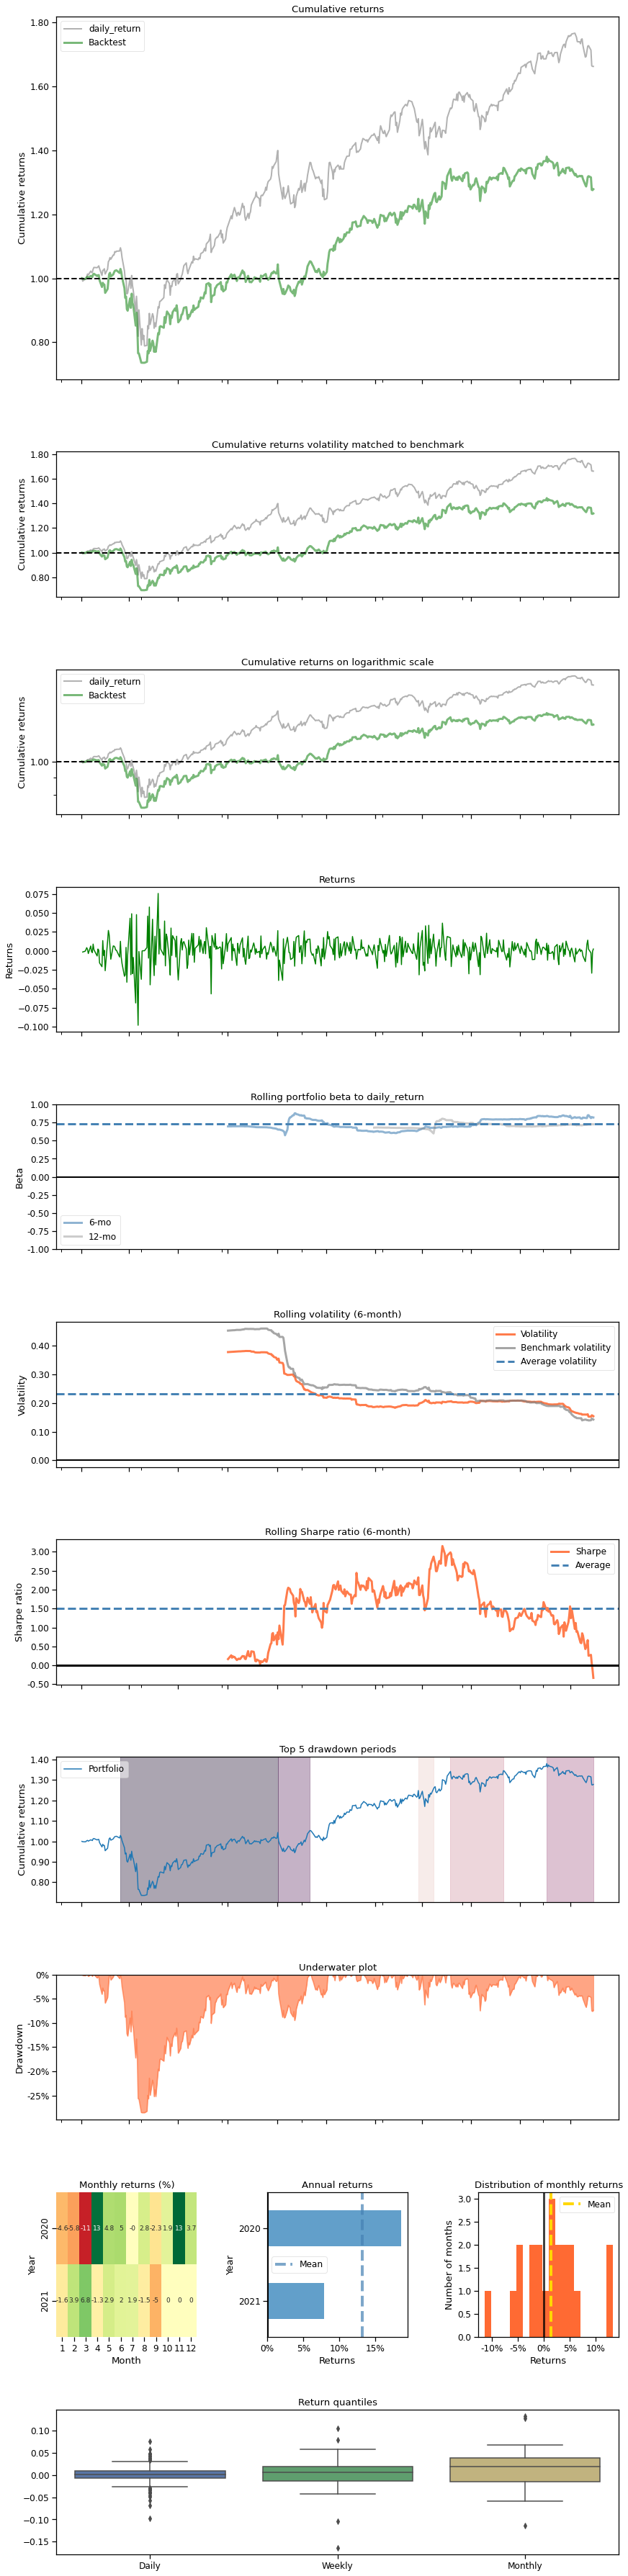

In [ ]:
# Model 5: SAC (Normal Env)
print("==========Compare SAC To Benchmark==========")
%matplotlib inline
backtest_plot(df_account_value_sac, 
              baseline_ticker = 'NDX', 
              baseline_start = df_account_value_sac.loc[0,'date'],
              baseline_end = df_account_value_sac.loc[len(df_account_value_sac)-1,'date'])